In [41]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from datetime import datetime
import requests


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", color_sequence)
plt.style.use('ggplot')

In [43]:
df = pd.read_csv("./out/uadb.csv")

C:\Users\faust\AppData\Local\Temp\ipykernel_188256\944338035.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./out/uadb.csv")


In [44]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [45]:
def get_year(row) -> int:
    try:
        year = row['date'].year
        #month = row['date'].month
        return int(year)
    except Exception as e:
        print(row)
        return np.nan
    
def get_month(row) -> int:
    try:
        month = row['date'].month
        return int(month)
    except Exception as e:
        print(row)
        return np.nan

In [46]:
df['year']= df.apply(get_year, axis=1)
df['month']= df.apply(get_month, axis=1)

date                                                         NaT
source                                                    UFODNA
description    Dark 'flying ship' hovers in place during wind...
city                                                         NaN
state                                                  CHERBOURG
country                                                       FR
water                                                        NaN
latitude                                                49.51113
longitude                                               -1.55471
word_count                                                    15
Name: 336560, dtype: object
date                                                         NaT
source                                                    UFODNA
description    Fishermen incident.\nA hovering object was obs...
city                                                         NaN
state                                                  STRALSU

In [47]:
df.dropna(subset=['year'], inplace=True)

In [48]:
today = datetime.today().strftime('%Y-%m-%d')
df.to_parquet(f"./out/uadb_{today}.parquet")

In [50]:
tmp = df.groupby('country')['country'].count().reset_index(name='total_sightings').sort_values(by='total_sightings', ascending=False)
tmp = tmp[:15]

<Axes: title={'center': 'Total Sightings | Top 20 Countries'}, xlabel='Country', ylabel='Sightings'>

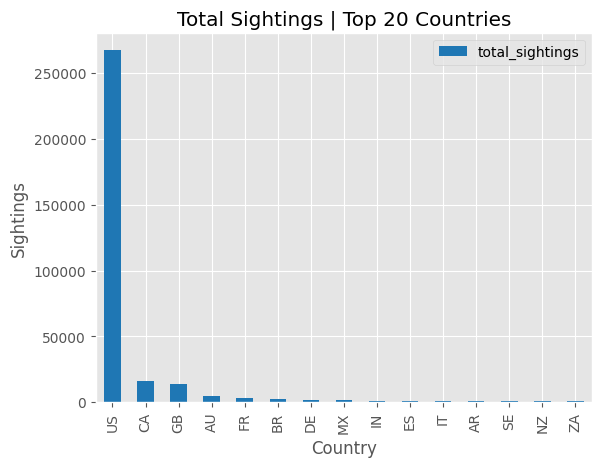

In [54]:
tmp.plot(
    kind='bar', 
    x='country', 
    y='total_sightings',
    grid=True,
    title="Total Sightings | Top 20 Countries",
    xlabel="Country",
    ylabel="Sightings",
    cmap=cmap)

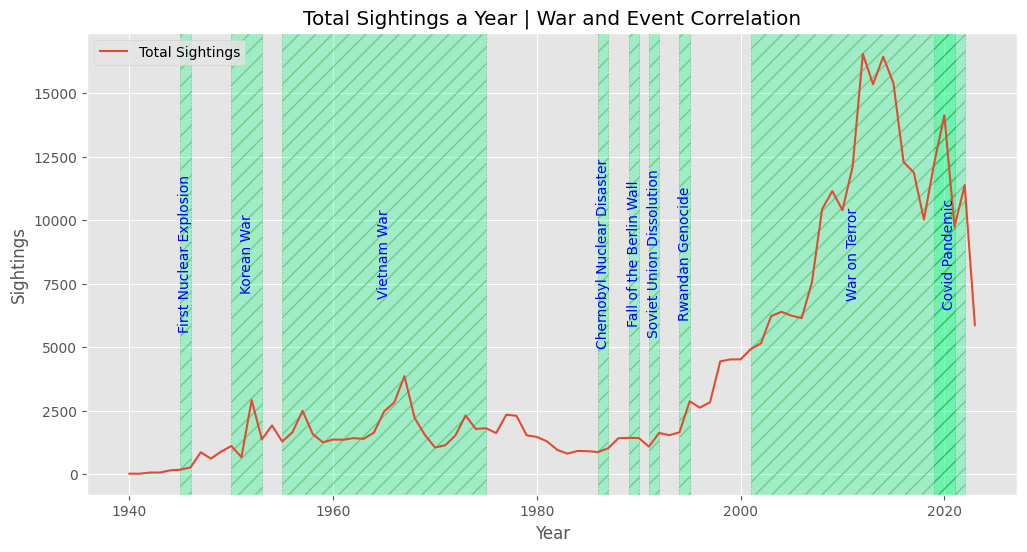

In [169]:
tmp = df[
    (df['year'] >= 1940)
    ].copy()

by_year_1900 = tmp.groupby('year')['year'].count().reset_index(name='total_year').sort_values(by='year', ascending=False)
ax = by_year_1900.plot(kind='line', x='year', y='total_year', figsize=(12, 6), grid=True, title="Total Sightings a Year | Global Event Correlation", xlabel="Year", ylabel="Sightings")
ax.legend(['Total Sightings'])

events = {
    'First Nuclear Explosion': [1945, 1946],
    'Covid Pandemic': [2019, 2022],
    'Vietnam War': [1955, 1975],
    "Korean War": [1950, 1953],
    "War on Terror": [2001, 2021],
    "Chernobyl Nuclear Disaster": [1986, 1987],
    "Fall of the Berlin Wall": [1989, 1990],
    "Soviet Union Dissolution": [1991, 1992],
    "Rwandan Genocide": [1994, 1995],
}

for event, dates in events.items():
    start_date = dates[0]
    end_date = dates[1]
    event_date = (start_date + end_date) / 2  # Calculate the middle date
    ax.axvspan(start_date, end_date, alpha=0.3, edgecolor='green', facecolor="springgreen", linestyle='--', label=event, hatch='//')
    ax.text(event_date, ax.get_ylim()[1]/2, event, color='blue', ha='center', va='center', rotation=90, fontsize=10)

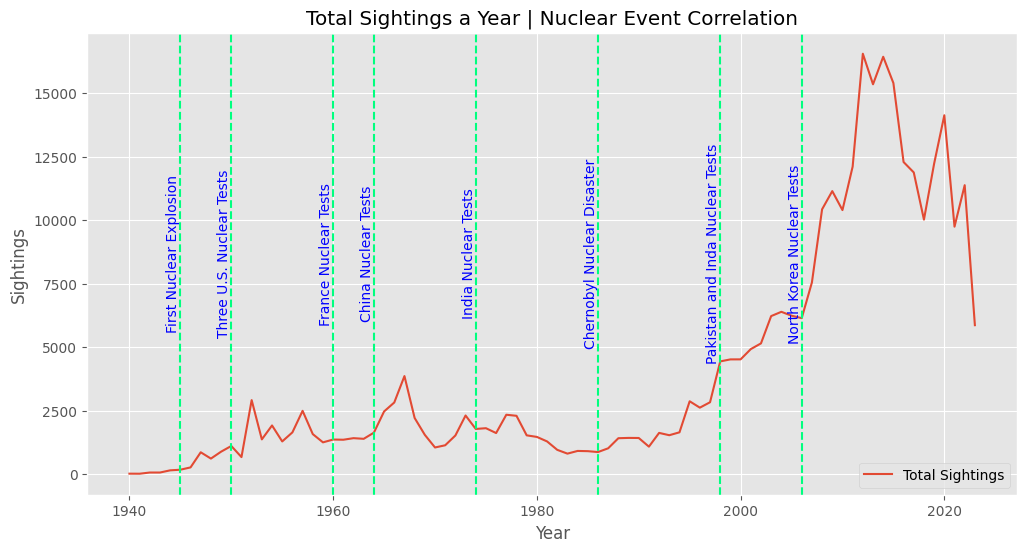

In [168]:
by_year_1900 = tmp.groupby('year')['year'].count().reset_index(name='total_year').sort_values(by='year', ascending=False)
ax = by_year_1900.plot(kind='line', x='year', y='total_year', figsize=(12, 6), grid=True, title="Total Sightings a Year | Nuclear Event Correlation", xlabel="Year", ylabel="Sightings")
ax.legend(['Total Sightings'])

events = {
    'First Nuclear Explosion': 1945,
    'Three U.S. Nuclear Tests': 1950,
    'France Nuclear Tests': 1960,
    'China Nuclear Tests': 1964,
    'India Nuclear Tests': 1974,
    'Chernobyl Nuclear Disaster': 1986,
    'Pakistan and Inda Nuclear Tests': 1998,
    'North Korea Nuclear Tests': 2006,

}

for event, date in events.items():
    start_date = dates[0]
    end_date = dates[1]
    event_date = (start_date + end_date) / 2  # Calculate the middle date
    ax.axvline(x=date, color='springgreen', linestyle='--', label='Event Year')
    ax.text(date, ax.get_ylim()[1]/2, event, color='blue', ha='right', va='center', rotation=90, fontsize=10)

In [149]:
r = requests.get("https://www.armscontrol.org/factsheets/nucleartesttally")
nuke_tests = pd.read_html(r.text)


In [150]:
nuke_tests_1 = nuke_tests[1]

In [151]:
nuke_tests_1.columns = ["Year", "United States", "USSR/Russia", "United Kingdom", "France", "China", "India", "Pakistan", "North Korea", "Total"]
nuke_tests_1 = nuke_tests_1[2:]
nuke_tests_1.to_parquet("./data/all_nuclear_tests.parquet")

In [163]:
def check(tests) -> bool:
    bad_tests = ["0", 0, np.nan]
    if tests not in bad_tests:
        return True
    return False

nuke_tests_dict = {}
for index, row in nuke_tests_1.iterrows():

    try:
        year = int(row['Year'])
    except:
        continue

    data = {
        "United States" : row['United States'],
        "USSR/Russia" : row['USSR/Russia'],
        "United Kingdom" : row['United Kingdom'],
        "France" : row['France'],
        "China" : row['China'],
        "India" : row['India'],
        "Pakistan" : row['Pakistan'],
        "North Korea" : row['North Korea'],
    }

    for contry, tests in data.items():
        if check(tests):
            nuke_tests_dict[f'{contry} | {row["Year"]} | {int(tests)} Tests'] = year

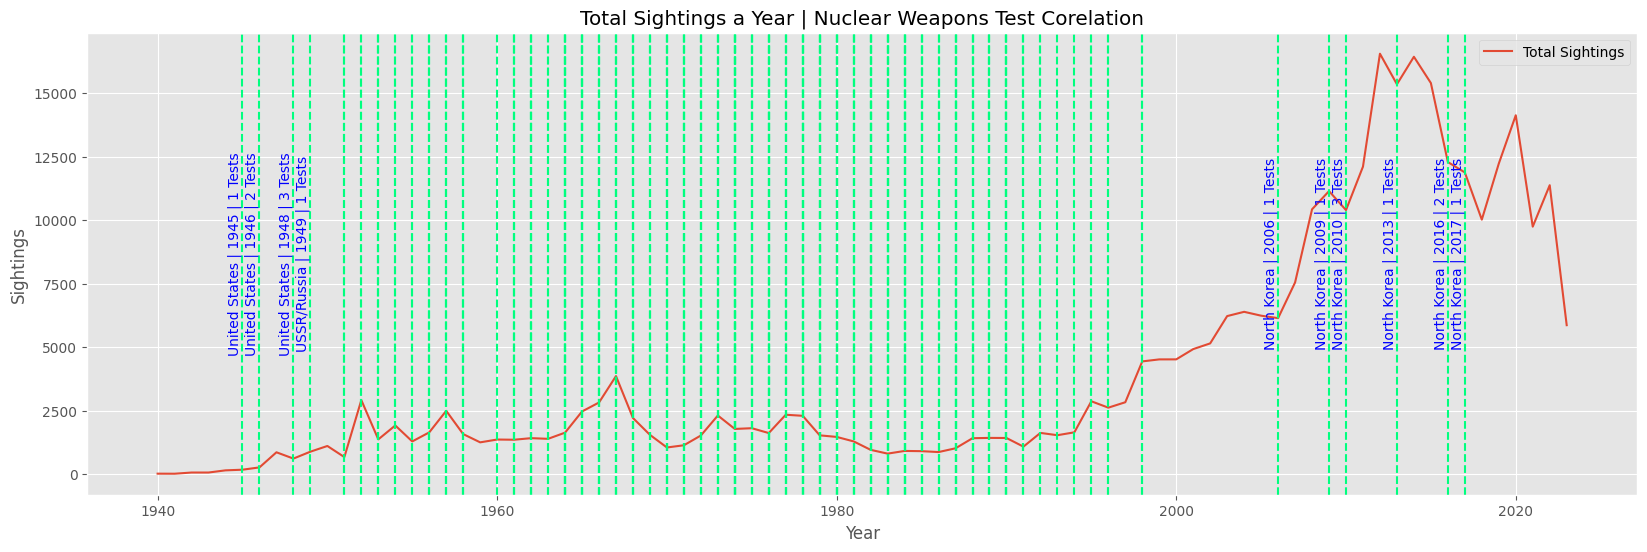

In [167]:
by_year_1900 = tmp.groupby('year')['year'].count().reset_index(name='total_year').sort_values(by='year', ascending=False)
ax = by_year_1900.plot(kind='line', x='year', y='total_year', figsize=(20, 6), grid=True, title="Total Sightings a Year | Nuclear Weapons Test Corelation", xlabel="Year", ylabel="Sightings")
ax.legend(['Total Sightings'])

for event, date in nuke_tests_dict.items():
    event_date = (start_date + end_date) / 2  # Calculate the middle date
    ax.axvline(x=date, color='springgreen', linestyle='--', label='Event Year')
    if date < 1950 or date > 2000:
        ax.text(date, ax.get_ylim()[1]/2, event, color='blue', ha='right', va='center', rotation=90, fontsize=10)
